___
# Facial Expression Recognition Library
___

In this project, I will aspired to libraries such as Sci_kit learn and create a plug-in neural network library

This was a Kaggle competition from 2013. I used the data to practice different models on the data. Following is overview of the competition and the data:


    One motivation for representation learning is that learning algorithms can design features better and faster than humans can. To this end, we hold this challenge that does not explicitly require that entries use representation learning. Rather, we introduce an entirely new dataset and invite competitors from all related communities to solve it. The dataset for this challenge is a facial expression classification dataset that we have assembled from the internet. Because this is a newly introduced dataset, this contest will see which methods are the easiest to get quickly working on new data.
    
## Data
____

    The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

## Utilities
____
Comprised of utility functions

In [1]:
import numpy as np
import pandas as pd

In [51]:
def init_weight_and_bias(M1, M2):
    # M1: input size
    # M2: output size

    W = np.random.randn(M1, M2) / np.sqrt(M1 + M2)
    # matrix of M1 by M2, randomized initially to Gaussian normal, divided by square root of the fan-in plus fan-out.
    b = np.zeros(M2)
    # bias initalized as zeros
    return W.astype(np.float32), b.astype(np.float32)

In [21]:
def init_filter(shape, poolsz):
    # used for convolutional neural network
    w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:] / np.prod(poolsz)))
    return w.astype(np.float32)

In [22]:
# activation functions
def relu(x):
    return x * (x > 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    expX = np.exp(x)
    return expX / expX.sum(axis=1, keepdims=True)

In [23]:
# cost functions
def sigmoid_cost(T, Y):
    # calculates the cross entropy from the definition for sigmoid cost/ binary classification
    return -(T*np.log(Y) + (1-T)*np.log(1-Y)).sum()

def cost(T, Y):
    # general cross entropy function, works for softmax
    return -(T*np.log(Y)).sum()

def cost2(T, Y):
    # same as cost(), just uses the targets to index Y
    # instead of multiplying by a large indicator matrix with mostly 0s
    N = len(T)
    return -np.log(Y[np.arange(N), T]).mean()

In [4]:
# error rate related!
def error_rate(targets, predictions):
    return np.mean(targets != predictions)

In [46]:
# data cleaning related functions

def y2indicator(y):
    # convert y into indicator matrix
    # size will be N by K
    N = len(y)
    K = len(set(y))
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

def getData(balance_ones=True):
    # get facial expression data
    
    # images are 48x48 = 2304 size vectors
    
    #initialize empty list for X and Y
    Y = []
    X = []
    
    # open data
    first = True
    for line in open('input/fer2013.csv'):
        # skip first line
        if first:
            first = False
        else:
            row = line.split(',')
            # first column is labels -> y
            Y.append(int(row[0]))      
            # second column is space separated pixels
            X.append([int(p) for p in row[1].split()])

    # convert these into Numpy array
    # and also normalize the data
    X = np.array(X) / 255.0
    Y = np.array(Y)
    
    # because we have imbalance class problem, we will balance the class 1. 
    if balance_ones:
        # get all data except class 1
        X0, Y0 = X[Y!=1, :], Y[Y!=1]
        
        # get all class 1 data
        X1 = X[Y==1, :]
        
        # repeat the data 9 times
        X1 = np.repeat(X1, 9, axis=0)
        
        # stack the data for X0 and X1  
        # stack the data for Y0 and 1
        X = np.vstack([X0, X1])
        Y = np.concatenate((Y0, [1]*len(X1)))

    return X, Y

def getImageData():
    # keep image shape
    X, Y = getData()
    N, D = X.shape
    d = int(np.sqrt(D))
    X = X.reshape(N, 1, d, d)
    return X, Y

def getBinaryData():
    # same as getData function, except we only get binary data/ Y = 0, 1
    Y = []
    X = []
    first = True
    for line in open('input/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            y = int(row[0])
            if y == 0 or y == 1:
                Y.append(y)
                X.append([int(p) for p in row[1].split()])
    return np.array(X) / 255.0, np.array(Y)

___
## Artificial Neural Network for Binary Classification using ReLU and tanh
___
Create ANN class for facial expression recognition.
- Binary Classification (only between 0 and 1)
- One hidden layer
- uses relu and tanh as activation function.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

class ANN(object):
    def __init__(self, M):
        self.M = M

    def fit(self, X, Y, learning_rate=5e-6, reg=1.0, epochs=10000, show_fig=False):
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        N, D = X.shape
        self.W1 = np.random.randn(D, self.M) / np.sqrt(D)
        self.b1 = np.zeros(self.M)
        self.W2 = np.random.randn(self.M) / np.sqrt(self.M)
        self.b2 = 0

        costs = []
        best_validation_error = 1
        for i in range(epochs):
            # forward propagation and cost calculation
            pY, Z = self.forward(X)            

            # back propagation - gradient descent step
            
            # hidden-to-outer
            pY_Y = pY - Y # prediction minus the target
            self.W2 -= learning_rate*(Z.T.dot(pY_Y) + reg*self.W2) # update hidden-to-output weight
            self.b2 -= learning_rate*((pY_Y).sum() + reg*self.b2) # update hidden-out-output bias

            # print "(pY_Y).dot(self.W2.T) shape:", (pY_Y).dot(self.W2.T).shape
            # print "Z shape:", Z.shape

            # input-to-hidden
            dZ = np.outer(pY_Y, self.W2) * (1 - Z*Z) # tanh
            # dZ = np.outer(pY_Y, self.W2) * (Z > 0) # ReLU
            
            self.W1 -= learning_rate*(X.T.dot(dZ) + reg*self.W1) # update input-to-hidden weight
            self.b1 -= learning_rate*(np.sum(dZ, axis=0) + reg*self.b1) # update input-to-hidden bias
            
            if i % 20 == 0:
                pYvalid, _ = self.forward(Xvalid)

                c = sigmoid_cost(Yvalid, pYvalid)

                costs.append(c)
                e = error_rate(Yvalid, np.round(pYvalid))
                print("i:", i, "cost:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print("best_validation_error:", best_validation_error)
        print("validation score: ", self.score(Xvalid, Yvalid))
        
        if show_fig:
            plt.plot(costs)
            plt.show()


    def forward(self, X):
        Z = np.tanh(X.dot(self.W1) + self.b1) # tanh
        # Z = relu(X.dot(self.W1) + self.b1) # ReLU

        return sigmoid(Z.dot(self.W2) + self.b2), Z


    def predict(self, X):
        pY = self.forward(X)
        return np.round(pY)


    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)

#     def main():
#         X, Y = getBinaryData()

#         X0 = X[Y==0, :]
#         X1 = X[Y==1, :]
#         X1 = np.repeat(X1, 9, axis=0)
#         X = np.vstack([X0, X1])
#         Y = np.array([0]*len(X0) + [1]*len(X1))

#         model = ANN(100)
#         model.fit(X, Y, show_fig=True)

# if __name__ == '__main__':
#     main()

In [9]:
# Try Using ANN class!
X, Y = getBinaryData()

# balance imbalance problem in the data
X0 = X[Y==0, :]
X1 = X[Y==1, :]
# repeat class 1, 9 times
X1 = np.repeat(X1, 9, axis=0)
# stack X and Y
X = np.vstack([X0, X1])
Y = np.array([0]*len(X0) + [1]*len(X1))

In [10]:
# initialize the model
model = ANN(100) # hidden layer size to 100

# fit the data into the model, use tanh activation. ** note: after testing few times, relu activation function doesn't behave well in this model.
model.fit(X , Y, show_fig=True, epochs = 10000)
print(model.score(X_test, y_test))

i: 0 cost: 907.9031569265344 error: 0.491
i: 20 cost: 674.8802333124743 error: 0.39
i: 40 cost: 661.2187813384332 error: 0.374
i: 60 cost: 660.5005201358624 error: 0.408
i: 80 cost: 661.9028229698006 error: 0.403
i: 100 cost: 660.0785223186659 error: 0.398
i: 120 cost: 659.1962193307143 error: 0.397
i: 140 cost: 657.9415350207827 error: 0.395
i: 160 cost: 656.143801648696 error: 0.39
i: 180 cost: 654.2385352410699 error: 0.383
i: 200 cost: 652.4658503916622 error: 0.382
i: 220 cost: 650.8492752291222 error: 0.384
i: 240 cost: 649.331409254781 error: 0.379
i: 260 cost: 647.8626775032702 error: 0.38
i: 280 cost: 646.4226262037051 error: 0.376
i: 300 cost: 645.0036242768244 error: 0.379
i: 320 cost: 643.6014100601981 error: 0.379
i: 340 cost: 642.2134263708137 error: 0.377
i: 360 cost: 640.8376247089001 error: 0.376
i: 380 cost: 639.4716255871501 error: 0.375
i: 400 cost: 638.1128991194603 error: 0.374
i: 420 cost: 636.7591816241797 error: 0.374
i: 440 cost: 635.4086215267059 error: 0.372

i: 3680 cost: 423.844908312184 error: 0.205
i: 3700 cost: 422.4064635702618 error: 0.205
i: 3720 cost: 420.9697070541321 error: 0.204
i: 3740 cost: 419.53472537265054 error: 0.203
i: 3760 cost: 418.101622865153 error: 0.202
i: 3780 cost: 416.670520382023 error: 0.201
i: 3800 cost: 415.2415533557944 error: 0.199
i: 3820 cost: 413.8148693116872 error: 0.197
i: 3840 cost: 412.390624991349 error: 0.197
i: 3860 cost: 410.9689832716482 error: 0.194
i: 3880 cost: 409.55011005267966 error: 0.193
i: 3900 cost: 408.1341712686259 error: 0.192
i: 3920 cost: 406.7213301456079 error: 0.192
i: 3940 cost: 405.3117447964328 error: 0.189
i: 3960 cost: 403.90556620711595 error: 0.189
i: 3980 cost: 402.5029366374169 error: 0.187
i: 4000 cost: 401.10398842966913 error: 0.187
i: 4020 cost: 399.70884319816406 error: 0.185
i: 4040 cost: 398.317611355772 error: 0.183
i: 4060 cost: 396.93039192509707 error: 0.182
i: 4080 cost: 395.5472725776706 error: 0.182
i: 4100 cost: 394.1683298455831 error: 0.181
i: 4120 c

KeyboardInterrupt: 

## Artificial Neural Network Multiple Classfication with Softmax
___

In [11]:
class ANNwithSoftmax(object):
    def __init__(self, M):
        self.M = M

    def fit(self, X, Y, learning_rate=10e-6, reg=10e-1, epochs=10000, show_fig=False):
        X, Y = shuffle(X, Y)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        # Tvalid = y2indicator(Yvalid)
        X, Y = X[:-1000], Y[:-1000]

        N, D = X.shape
        K = len(set(Y))
        T = y_to_indicator(Y)
        
        # input-to-hidden layer
        self.W1 = np.random.randn(D, self.M) / np.sqrt(D)
        self.b1 = np.zeros(self.M)
        
        # hidden-to-output layer
        self.W2 = np.random.randn(self.M, K) / np.sqrt(self.M)
        self.b2 = np.zeros(K)

        costs = []
        best_validation_error = 1
        for i in range(epochs):
            # forward propagation and cost calculation
            pY, Z = self.forward(X)

            # gradient descent step
            pY_T = pY - T
            self.W2 -= learning_rate*(Z.T.dot(pY_T) + reg*self.W2)
            self.b2 -= learning_rate*(pY_T.sum(axis=0) + reg*self.b2)
            
            # dZ = pY_T.dot(self.W2.T) * (Z > 0) # relu
            dZ = pY_T.dot(self.W2.T) * (1 - Z*Z) # tanh
            
            self.W1 -= learning_rate*(X.T.dot(dZ) + reg*self.W1)
            self.b1 -= learning_rate*(dZ.sum(axis=0) + reg*self.b1)

            if i % 20 == 0:
                pYvalid, _ = self.forward(Xvalid)
                c = cost2(Yvalid, pYvalid)
                costs.append(c)
                e = error_rate(Yvalid, np.argmax(pYvalid, axis=1))
                print("i:", i, "cost:", c, "error:", e)
                if e < best_validation_error:
                    best_validation_error = e
        print("best_validation_error:", best_validation_error)
        print("validation score: ", self.score(Xvalid, Yvalid))

        if show_fig:
            plt.plot(costs)
            plt.show()


    def forward(self, X):
        # Z = relu(X.dot(self.W1) + self.b1)
        Z = np.tanh(X.dot(self.W1) + self.b1)
        return softmax(Z.dot(self.W2) + self.b2), Z

    def predict(self, X):
        pY, _ = self.forward(X)
        return np.argmax(pY, axis=1)

    def score(self, X, Y):
        prediction = self.predict(X)
        return 1 - error_rate(Y, prediction)


# def main():
#     X, Y = getData()
    
#     model = ANN(200)
#     model.fit(X, Y, reg=0, show_fig=True)
#     print(model.score(X, Y))
#     # scores = cross_val_score(model, X, Y, cv=5)
#     # print "score mean:", np.mean(scores), "stdev:", np.std(scores)

# if __name__ == '__main__':
#     main()


i: 0 cost: 4.176066641187003 error: 0.516
i: 20 cost: 4.799642246762398 error: 0.516
i: 40 cost: 5.303824425901825 error: 0.516
i: 60 cost: 5.79741145915397 error: 0.516
i: 80 cost: 6.11922547959057 error: 0.516
i: 100 cost: 6.258828662922845 error: 0.516
i: 120 cost: 6.314284146357235 error: 0.516
i: 140 cost: 6.342854805581711 error: 0.516
i: 160 cost: 6.361919052360248 error: 0.516
i: 180 cost: 6.376343304131984 error: 0.516
i: 200 cost: 6.387873316895359 error: 0.516
i: 220 cost: 6.39737243359595 error: 0.516
i: 240 cost: 6.4053636280265795 error: 0.516
i: 260 cost: 6.412196182693226 error: 0.516
i: 280 cost: 6.418115802238994 error: 0.516
i: 300 cost: 6.423301404391709 error: 0.516
i: 320 cost: 6.427886792898999 error: 0.516
i: 340 cost: 6.431974254290928 error: 0.516
i: 360 cost: 6.4356434516825765 error: 0.516
i: 380 cost: 6.438957433030001 error: 0.516
i: 400 cost: 6.441966800332941 error: 0.516
i: 420 cost: 6.4447126700561155 error: 0.516
i: 440 cost: 6.447228817914773 error: 

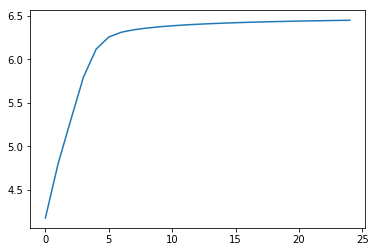

0.4992912110166059


In [13]:
model = ANNwithSoftmax(200)
model.fit(X, Y, reg=0, show_fig=True)
print(model.score(X, Y))
# scores = cross_val_score(model, X, Y, cv=5)
# print "score mean:", np.mean(scores), "stdev:", np.std(scores)

## Using Tensorflow
___


In [10]:
import tensorflow as tf
from sklearn.utils import shuffle

In [36]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]
        
    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)
    
class ANN_TF(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=1e-2, mu=0.99, decay=0.999, reg=1e-3, epochs=10, batch_sz=100, show_fig=False):
        K = len(set(Y)) # won't work later b/c we turn it into indicator

        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = y_to_indicator(Y).astype(np.float32)
        # Y = Y.astype(np.int32)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        Yvalid_flat = np.argmax(Yvalid, axis=1) # for calculating error rate
        X, Y = X[:-1000], Y[:-1000]

        # initialize hidden layers
        N, D = X.shape
        
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # set up theano functions and variables
        tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
        tfT = tf.placeholder(tf.float32, shape=(None, K), name='T')
        act = self.forward(tfX)

        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                logits=act,
                labels=tfT
            )
        ) + rcost
        prediction = self.predict(tfX)
        train_op = tf.train.RMSPropOptimizer(learning_rate, decay=decay, momentum=mu).minimize(cost)

        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfT: Ybatch})

                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        if show_fig:
            plt.plot(costs)
            plt.show()
            
    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)

        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        act = self.forward(X)
        return tf.argmax(act, 1)

In [37]:
# run the data
X, Y = getData()
model = ANN_TF([2000, 1000])
model.fit(X, Y, show_fig = True)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

i: 0 j: 0 nb: 392 cost: 2.8192596 error rate: 0.849
i: 0 j: 20 nb: 392 cost: 2.766212 error rate: 0.77
i: 0 j: 40 nb: 392 cost: 2.7515898 error rate: 0.733
i: 0 j: 60 nb: 392 cost: 2.7332249 error rate: 0.751
i: 0 j: 80 nb: 392 cost: 2.7334073 error rate: 0.773
i: 0 j: 100 nb: 392 cost: 2.6375074 error rate: 0.699
i: 0 j: 120 nb: 392 cost: 2.7434754 error rate: 0.705
i: 0 j: 140 nb: 392 cost: 2.606319 error rate: 0.74
i: 0 j: 160 nb: 392 cost: 2.5954235 error rate: 0.722
i: 0 j: 180 nb: 392 cost: 2.5480108 error rate: 0.694
i: 0 j: 200 nb: 392 cost: 2.6018639 error rate: 0.751
i: 0 j: 220 nb: 392 cost: 2.5449119 error rate: 0.776
i: 0 j: 240 nb: 392 cost: 2.5479531 error rate: 0.731
i: 0 j: 260 nb: 392 cost: 2.5007927 error rate: 0.7
i: 0 j: 280 nb: 392 cost: 2.498108 error rate: 0.705
i: 0 j: 300

KeyboardInterrupt: 

# Convolutional Neural Network
___

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.io import loadmat
from sklearn.utils import shuffle

In [38]:
class ConvPoolLayer(object):
    def __init__(self, mi, mo, fw=5, fh=5, poolsz=(2, 2)):
        # mi = input feature map size
        # mo = output feature map size
        sz = (fw, fh, mi, mo)
        W0 = init_filter(sz, poolsz)
        self.W = tf.Variable(W0)
        b0 = np.zeros(mo, dtype=np.float32)
        self.b = tf.Variable(b0)
        self.poolsz = poolsz
        self.params = [self.W, self.b]

    def forward(self, X):
        conv_out = tf.nn.conv2d(X, self.W, strides=[1, 1, 1, 1], padding='SAME')
        conv_out = tf.nn.bias_add(conv_out, self.b)
        p1, p2 = self.poolsz
        pool_out = tf.nn.max_pool(
            conv_out,
            ksize=[1, p1, p2, 1],
            strides=[1, p1, p2, 1],
            padding='SAME'
        )
        return tf.tanh(pool_out)

In [48]:
class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]
        
    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)

In [49]:
class CNN_TF(object):
    def __init__(self, convpool_layer_sizes, hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes
        
    def fit(self, X, Y, learning_rate=1e-2, mu=0.99, decay=0.999, reg=1e-3, epochs=10, batch_sz=100, show_fig=False):
        lr = np.float32(learning_rate)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(epochs)
        K = len(set(Y))

        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y).astype(np.float32)

        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        Yvalid_flat = np.argmax(Yvalid, axis=1) # for calculating error rate

        # initialize convpool layers
        N, width, height, c = X.shape
        mi = c
        outw = width
        outh = height
        self.convpool_layers = []
        for mo, fw, fh in self.convpool_layer_sizes:
            layer = ConvPoolLayer(mi, mo, fw, fh)
            self.convpool_layers.append(layer)
            outw = outw // 2
            outh = outh // 2
            mi = mo

        # initialize mlp layers
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh # size must be same as output of last convpool layer
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1

        # logistic regression layer
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W, 'W_logreg')
        self.b = tf.Variable(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.convpool_layers:
            self.params += h.params
        for h in self.hidden_layers:
            self.params += h.params

        # set up tensorflow functions and variables
        tfX = tf.placeholder(tf.float32, shape=(None, width, height, c), name='X')
        tfY = tf.placeholder(tf.float32, shape=(None, K), name='Y')
        act = self.forward(tfX)

        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=act,
                labels=tfY
            )
        ) + rcost
        prediction = self.predict(tfX)

        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)

        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})

                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)

        if show_fig:
            plt.plot(costs)
            plt.show()
            
    def forward(self, X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z_shape = Z.get_shape().as_list()
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        pY = self.forward(X)
        return tf.argmax(pY, 1)

In [44]:
def rearrange(X):
    arr = np.zeros(shape=(X.shape[0], 48, 48))
    for i in range(X.shape[0]):
        arr[i] = np.reshape(X[i], (48, 48))
    
    return arr[..., np.newaxis]

In [41]:
X, Y = getData()

X = rearrange(X)

NameError: name 'CNN' is not defined

In [52]:
model = CNN_TF(
    convpool_layer_sizes=[(20, 5, 5), (20, 5, 5)],
    hidden_layer_sizes=[500, 300],
)

model.fit(X, Y, show_fig=True)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

i: 0 j: 0 nb: 392 cost: 2.282291 error rate: 0.894
i: 0 j: 20 nb: 392 cost: 2.2208674 error rate: 0.755
i: 0 j: 40 nb: 392 cost: 2.2134507 error rate: 0.755
i: 0 j: 60 nb: 392 cost: 2.1957757 error rate: 0.755
i: 0 j: 80 nb: 392 cost: 2.165794 error rate: 0.731
i: 0 j: 100 nb: 392 cost: 2.1235492 error rate: 0.717
i: 0 j: 120 nb: 392 cost: 2.033295 error rate: 0.682
i: 0 j: 140 nb: 392 cost: 1.9938495 error rate: 0.654
i: 0 j: 160 nb: 392 cost: 2.0390906 error rate: 0.648
i: 0 j: 180 nb: 392 cost: 1.9605522 error rate: 0.647
i: 0 j: 200 nb: 392 cost: 1.9673625 error rate: 0.639
i: 0 j: 220 nb: 392 cost: 1.9866122 error rate: 0.639
i: 0 j: 240 nb: 392 cost: 1.9514055 error rate: 0.65
i: 0 j: 260 nb: 392 cost: 1.8931465 error rate: 0.602
i: 0 j: 280 nb: 392 cost: 1.8454106 error rate: 0.585
i: 0 j: 

i: 7 j: 140 nb: 392 cost: 1.9062198 error rate: 0.755
i: 7 j: 160 nb: 392 cost: 1.9111195 error rate: 0.755
i: 7 j: 180 nb: 392 cost: 1.9032702 error rate: 0.755
i: 7 j: 200 nb: 392 cost: 1.9050959 error rate: 0.755
i: 7 j: 220 nb: 392 cost: 1.9098127 error rate: 0.755
i: 7 j: 240 nb: 392 cost: 1.8999878 error rate: 0.755
i: 7 j: 260 nb: 392 cost: 1.9003899 error rate: 0.755
i: 7 j: 280 nb: 392 cost: 1.9037112 error rate: 0.755
i: 7 j: 300 nb: 392 cost: 1.9218634 error rate: 0.755
i: 7 j: 320 nb: 392 cost: 1.903661 error rate: 0.755
i: 7 j: 340 nb: 392 cost: 1.8983796 error rate: 0.755
i: 7 j: 360 nb: 392 cost: 1.9082354 error rate: 0.755
i: 7 j: 380 nb: 392 cost: 1.9091247 error rate: 0.755
i: 8 j: 0 nb: 392 cost: 1.9138633 error rate: 0.755
i: 8 j: 20 nb: 392 cost: 1.9049928 error rate: 0.755
i: 8 j: 40 nb: 392 cost: 1.9048241 error rate: 0.755
i: 8 j: 60 nb: 392 cost: 1.9109169 error rate: 0.755
i: 8 j: 80 nb: 392 cost: 1.9179018 error rate: 0.755
i: 8 j: 100 nb: 392 cost: 1.9173846